In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

# Suppress warnings for cleaner report output
warnings.filterwarnings("ignore")

# Set a professional plotting style for the report figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 300

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [26]:
# Load the dataset
df = pd.read_csv('malaysia_consolidated_data_partial.csv')

# Ensure Year is treated as integer/datetime for indexing
df['Year'] = pd.to_numeric(df['Year'])

# Filter Data: 1990 to 2005 (The "Asian Tiger" and Crisis Recovery period)
df_model = df[(df['Year'] >= 1990) & (df['Year'] <= 2005)].copy()

# Set Year as Index for Time Series plotting
df_model.set_index('Year', inplace=True)

# Preview the data to ensure correct filtering
print(f"Sample Size (N): {len(df_model)}")
df_model.head()

Sample Size (N): 16


,INFRATE,GDPGR,REMITTANCE,M2GR,DCRISES
Year,,,,,
1990,2.617801,9.007499,0.420726,-46.940864,0
1991,4.358333,9.547444,0.264897,12.465518,0
1992,4.767228,8.886056,0.258754,74.230085,0
1993,3.536585,9.895734,0.262495,18.907702,0
1994,3.724971,9.211256,0.160143,14.606371,0


In [27]:
# Generate Summary Statistics
desc_stats = df_model[['INFRATE', 'GDPGR', 'REMITTANCE', 'M2GR', 'DCRISES']].describe()

# Transpose for better readability (like the LaTeX table)
print("--- Table 1: Descriptive Statistics ---")
print(desc_stats.T)

--- Table 1: Descriptive Statistics ---
            count      mean        std        min       25%       50%  \
INFRATE      16.0  2.929180   1.260684   1.089676  1.739589  2.859816   
GDPGR        16.0  6.537881   4.479623  -7.358840  5.689313  7.999009   
REMITTANCE   16.0  0.353538   0.180511   0.130540  0.242673  0.314967   
M2GR         16.0  7.647215  24.461495 -46.940864  2.905178  7.818402   
DCRISES      16.0  0.062500   0.250000   0.000000  0.000000  0.000000   

                  75%        max  
INFRATE      3.583682   5.270342  
GDPGR        9.295303  10.002040  
REMITTANCE   0.423383   0.778193  
M2GR        14.770817  74.230085  
DCRISES      0.000000   1.000000  


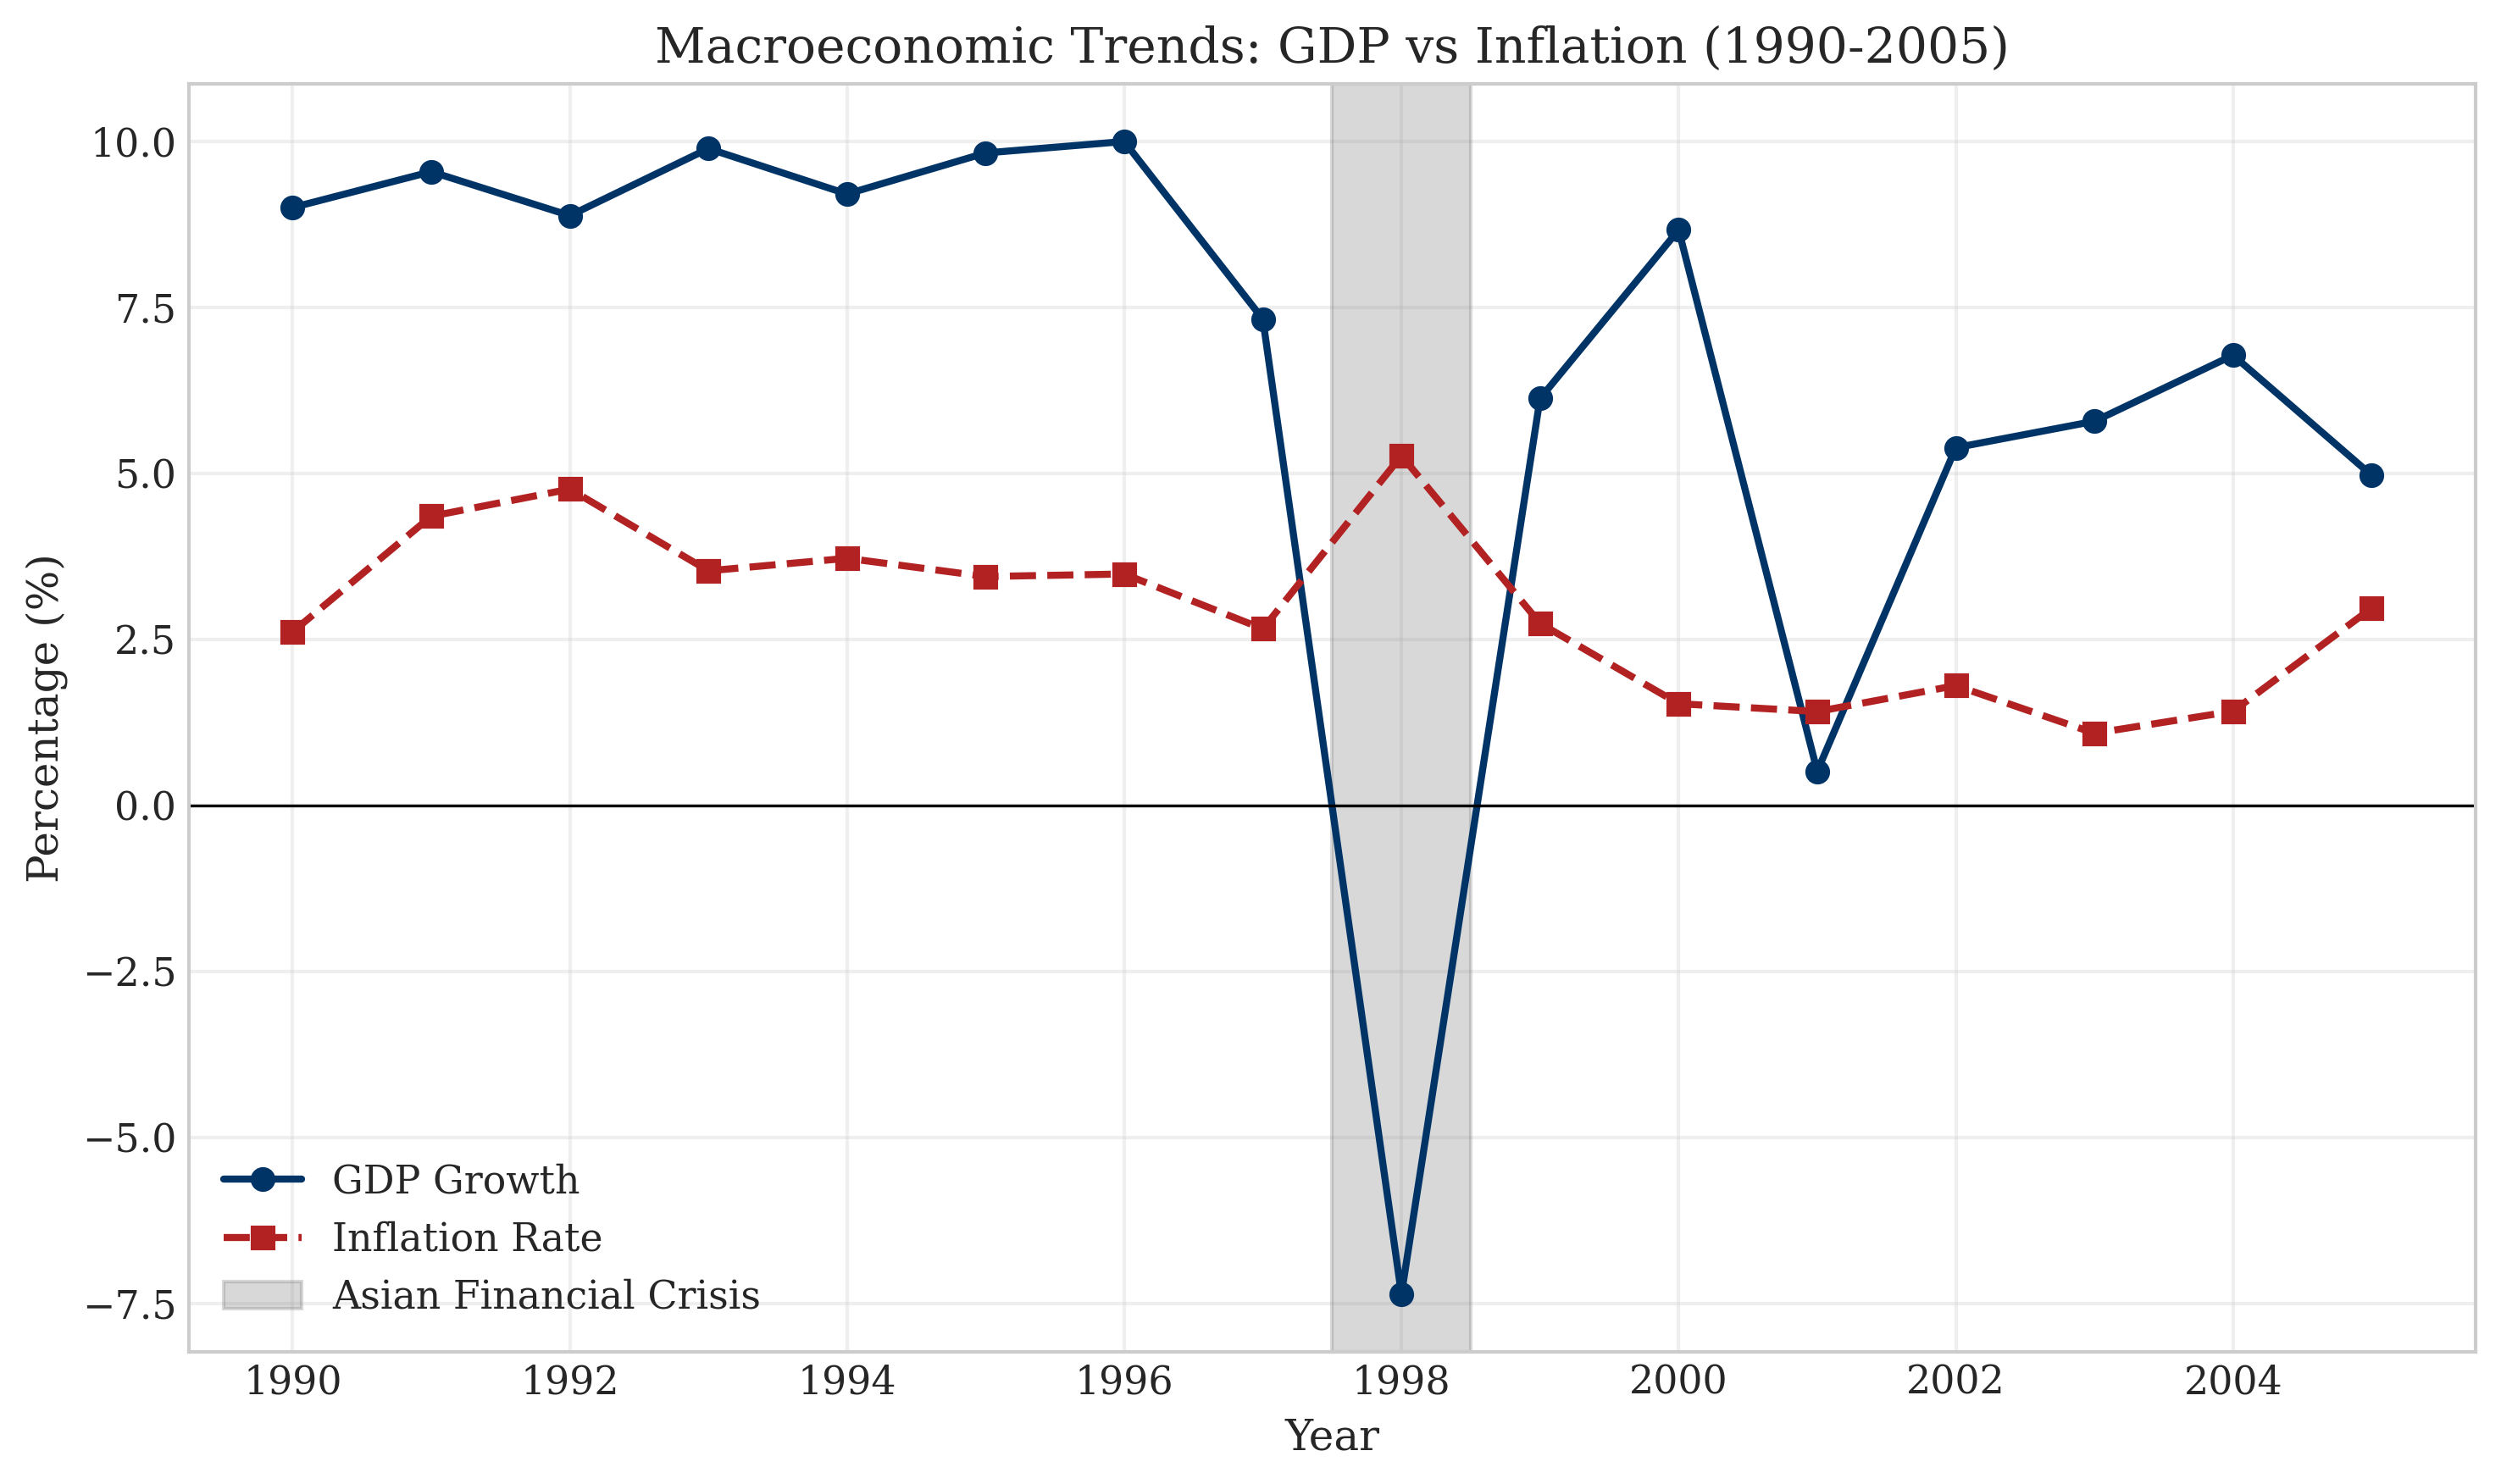

In [28]:
# Create Figure 1: Macroeconomic Trends
plt.figure(figsize=(10, 6))

# Plot GDP Growth
plt.plot(df_model.index, df_model['GDPGR'], label='GDP Growth', color='#003366', linewidth=2, marker='o')

# Plot Inflation
plt.plot(df_model.index, df_model['INFRATE'], label='Inflation Rate', color='#B22222', linewidth=2, linestyle='--', marker='s')

# Add Zero Line
plt.axhline(0, color='black', linewidth=0.8)

# Highlight the Asian Financial Crisis (1998)
plt.axvspan(1997.5, 1998.5, color='gray', alpha=0.3, label='Asian Financial Crisis')

# Formatting
plt.title('Macroeconomic Trends: GDP vs Inflation (1990-2005)', fontsize=14)
plt.ylabel('Percentage (%)')
plt.xlabel('Year')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)

# Save for LaTeX
plt.tight_layout()
plt.savefig('figure_trends.png')
plt.show()

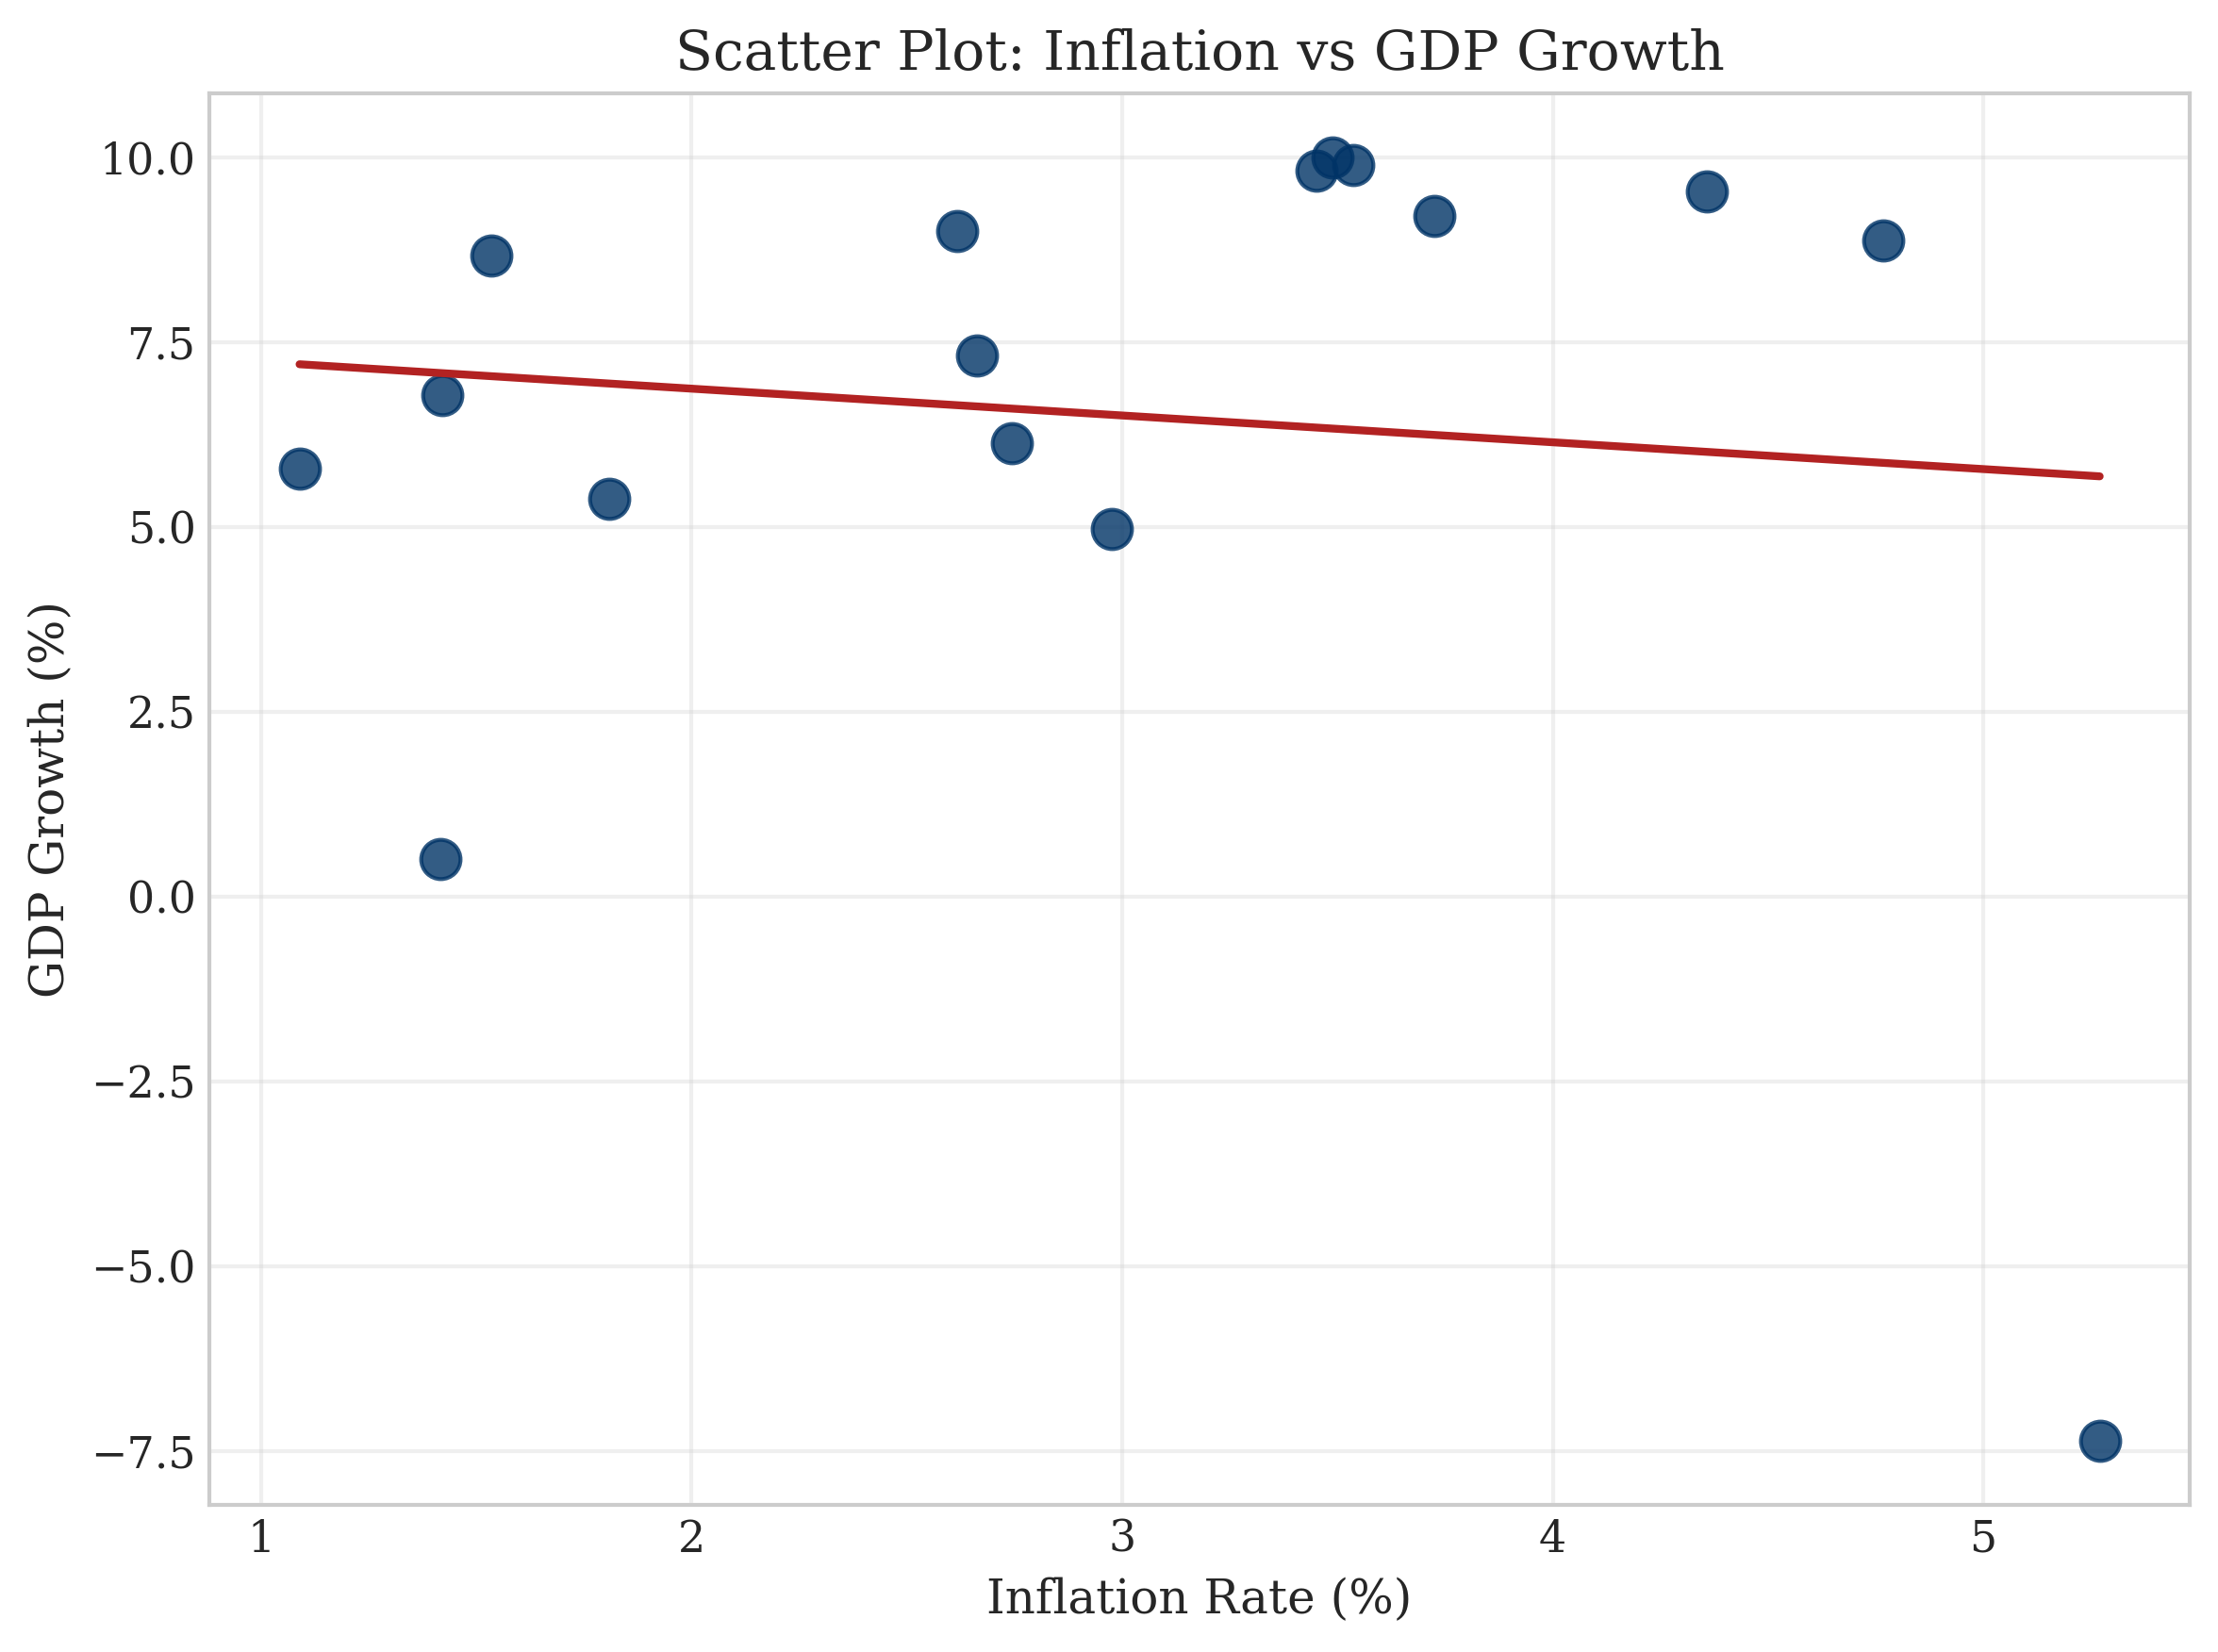

In [29]:
# Create Figure 2: Scatter Plot
plt.figure(figsize=(8, 6))

# Regression Plot using Seaborn
sns.regplot(x='INFRATE', y='GDPGR', data=df_model, 
            ci=None, 
            scatter_kws={'s': 100, 'color': '#003366'}, 
            line_kws={'color': '#B22222', 'linewidth': 2})

# Formatting
plt.title('Scatter Plot: Inflation vs GDP Growth', fontsize=14)
plt.xlabel('Inflation Rate (%)')
plt.ylabel('GDP Growth (%)')
plt.grid(True, alpha=0.3)

# Save for LaTeX
plt.tight_layout()
plt.savefig('figure_scatter.png')
plt.show()

In [30]:
# Define Variables
Y = df_model['GDPGR']
X = df_model[['INFRATE', 'M2GR', 'REMITTANCE', 'DCRISES']]

# Add Constant (Interecept)
X = sm.add_constant(X)

# Fit OLS Model
model_ols = sm.OLS(Y, X).fit()

# Print Summary
print("--- Initial OLS Regression Results ---")
print(model_ols.summary())

--- Initial OLS Regression Results ---
                            OLS Regression Results                            
Dep. Variable:                  GDPGR   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     14.40
Date:                Sat, 20 Dec 2025   Prob (F-statistic):           0.000238
Time:                        20:34:36   Log-Likelihood:                -31.535
No. Observations:                  16   AIC:                             73.07
Df Residuals:                      11   BIC:                             76.93
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

Jarque-Bera P-value: 0.02817 (Not Normal)
Breusch-Godfrey P-value: 0.15695
Breusch-Pagan P-value: 0.27559


<Figure size 2400x1800 with 0 Axes>

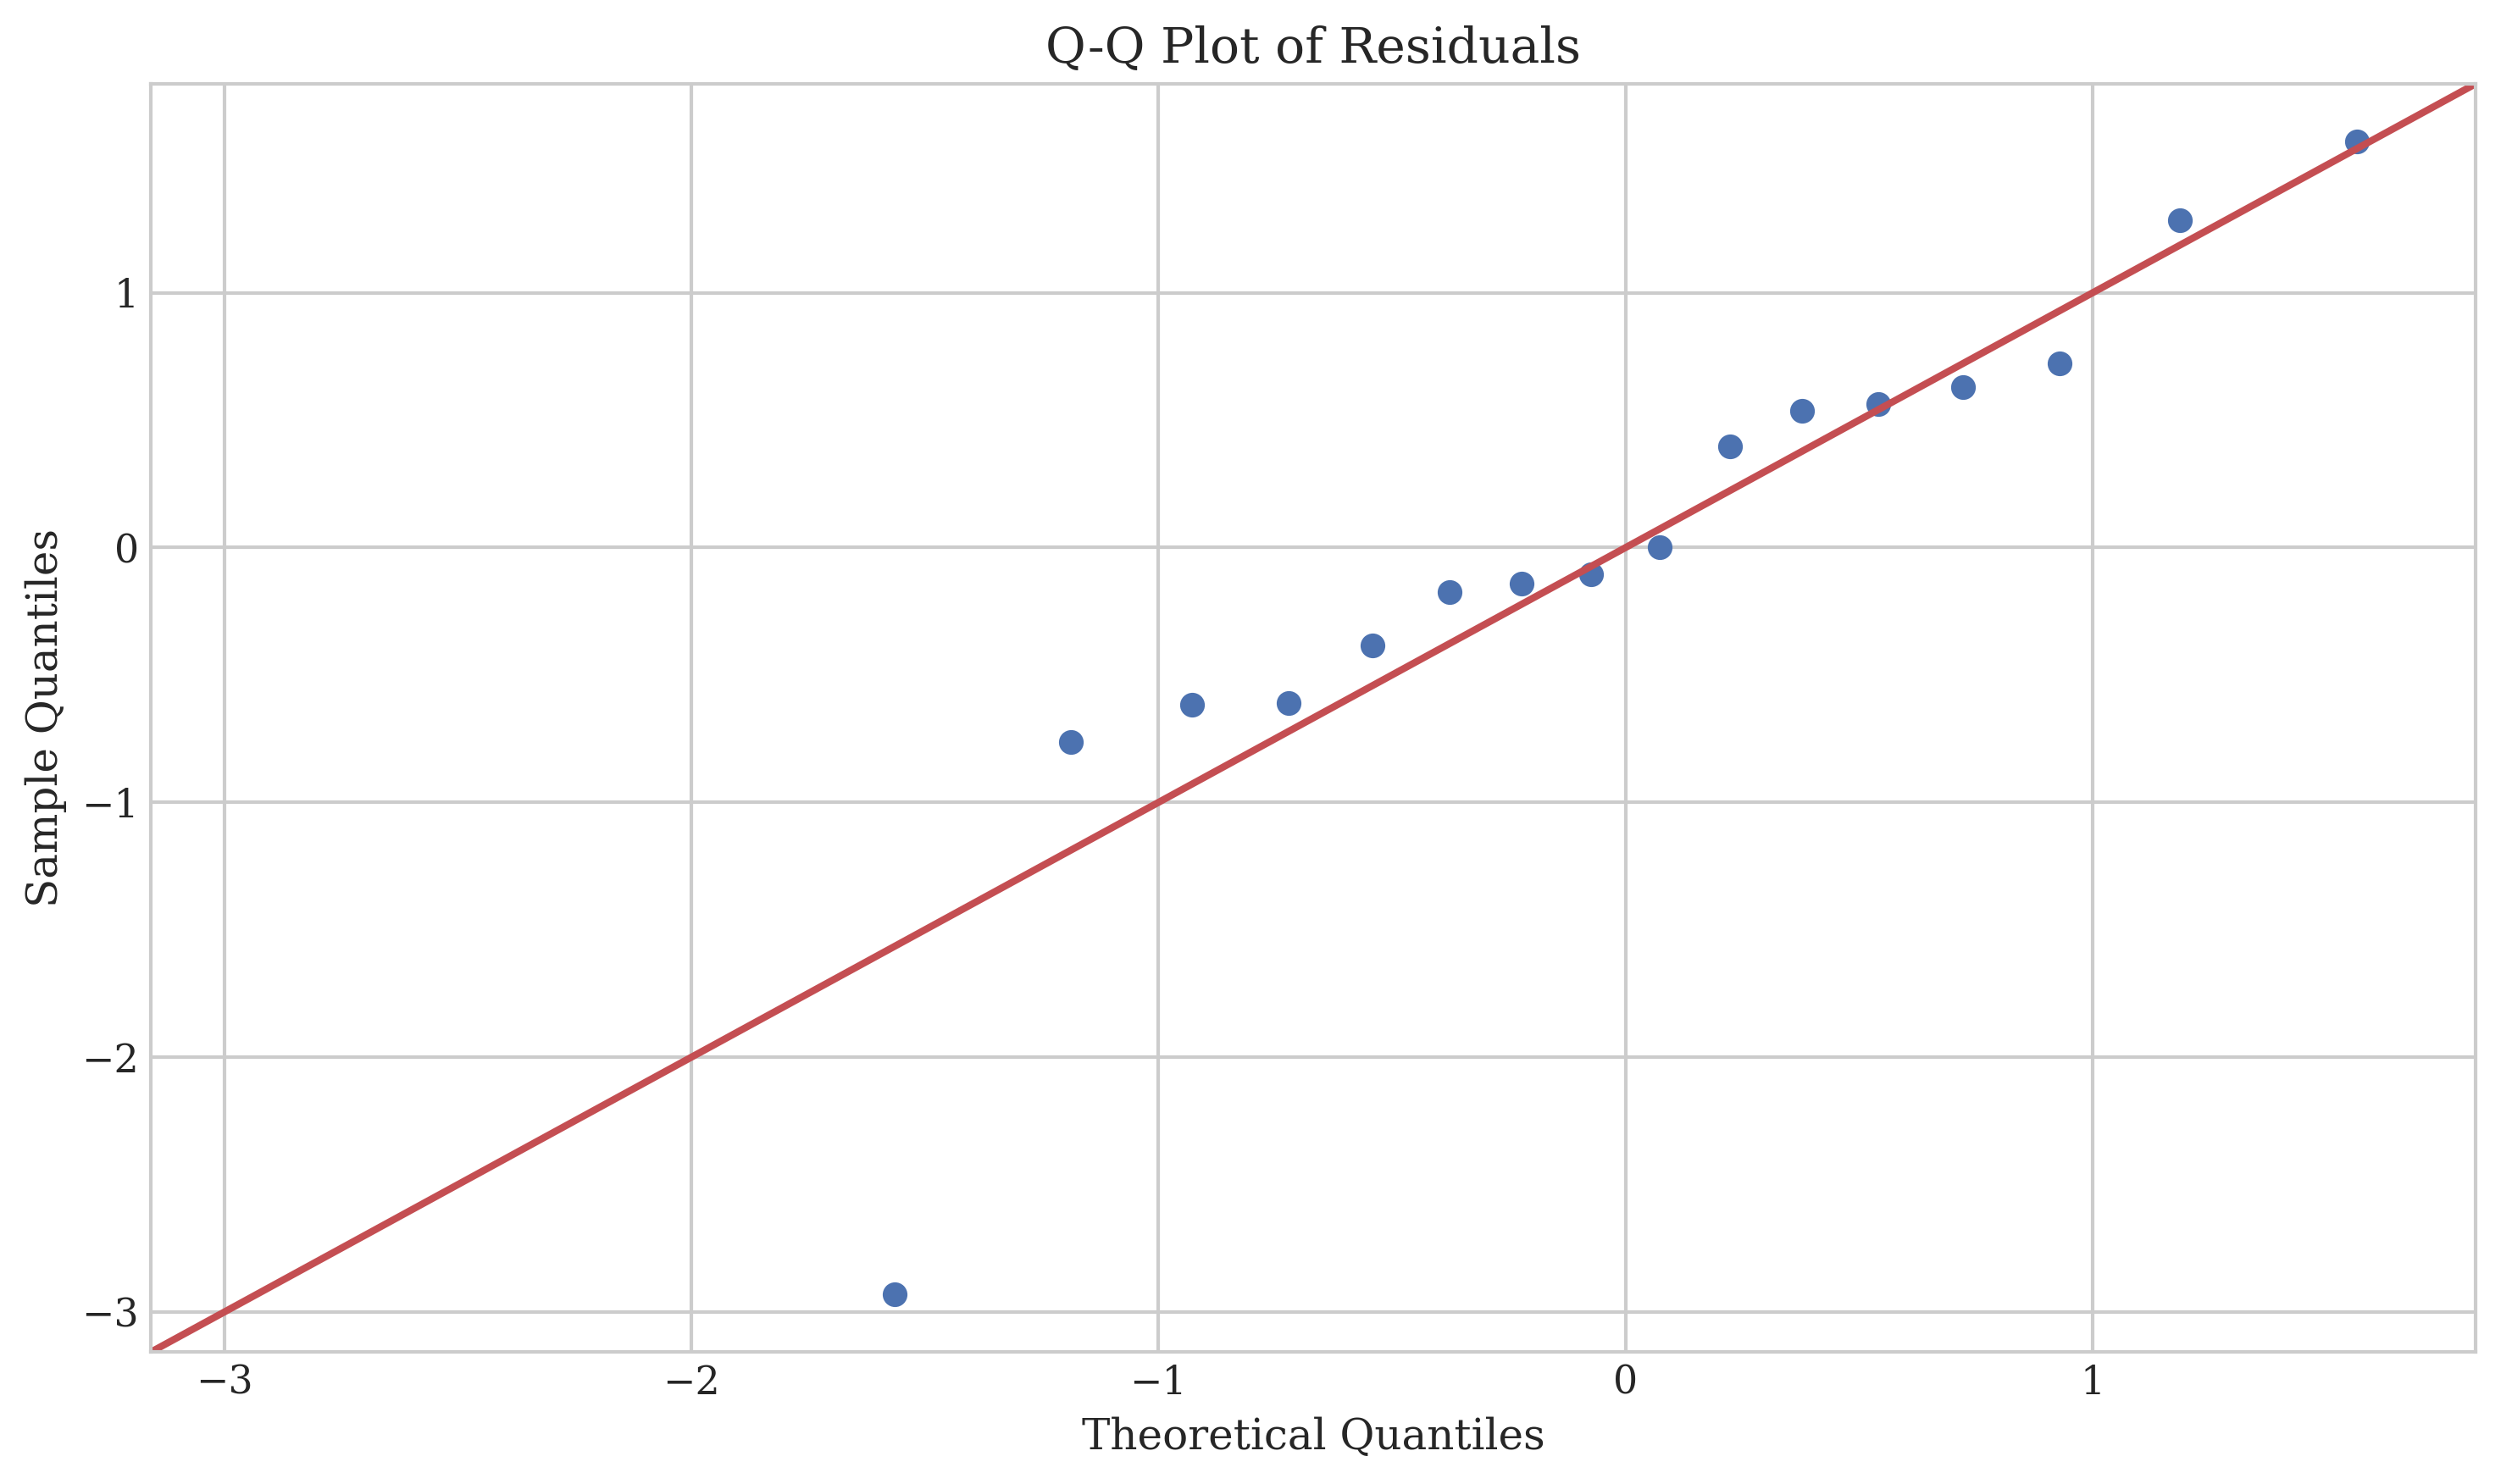

In [31]:
# 1. Normality Test (Jarque-Bera)
jb_stat, jb_pval, skew, kurt = jarque_bera(model_ols.resid)
print(f"Jarque-Bera P-value: {jb_pval:.5f} ({'Normal' if jb_pval > 0.05 else 'Not Normal'})")

# 2. Serial Correlation (Breusch-Godfrey)
bg_stat, bg_pval, _, _ = acorr_breusch_godfrey(model_ols, nlags=1)
print(f"Breusch-Godfrey P-value: {bg_pval:.5f}")

# 3. Heteroskedasticity (Breusch-Pagan)
bp_stat, bp_pval, _, _ = het_breuschpagan(model_ols.resid, X)
print(f"Breusch-Pagan P-value: {bp_pval:.5f}")

# 4. Visual Normality Check (Q-Q Plot)
plt.figure(figsize=(8, 6))
sm.qqplot(model_ols.resid, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.savefig('figure1_qq_plot.png') # Saved for Report
plt.show()

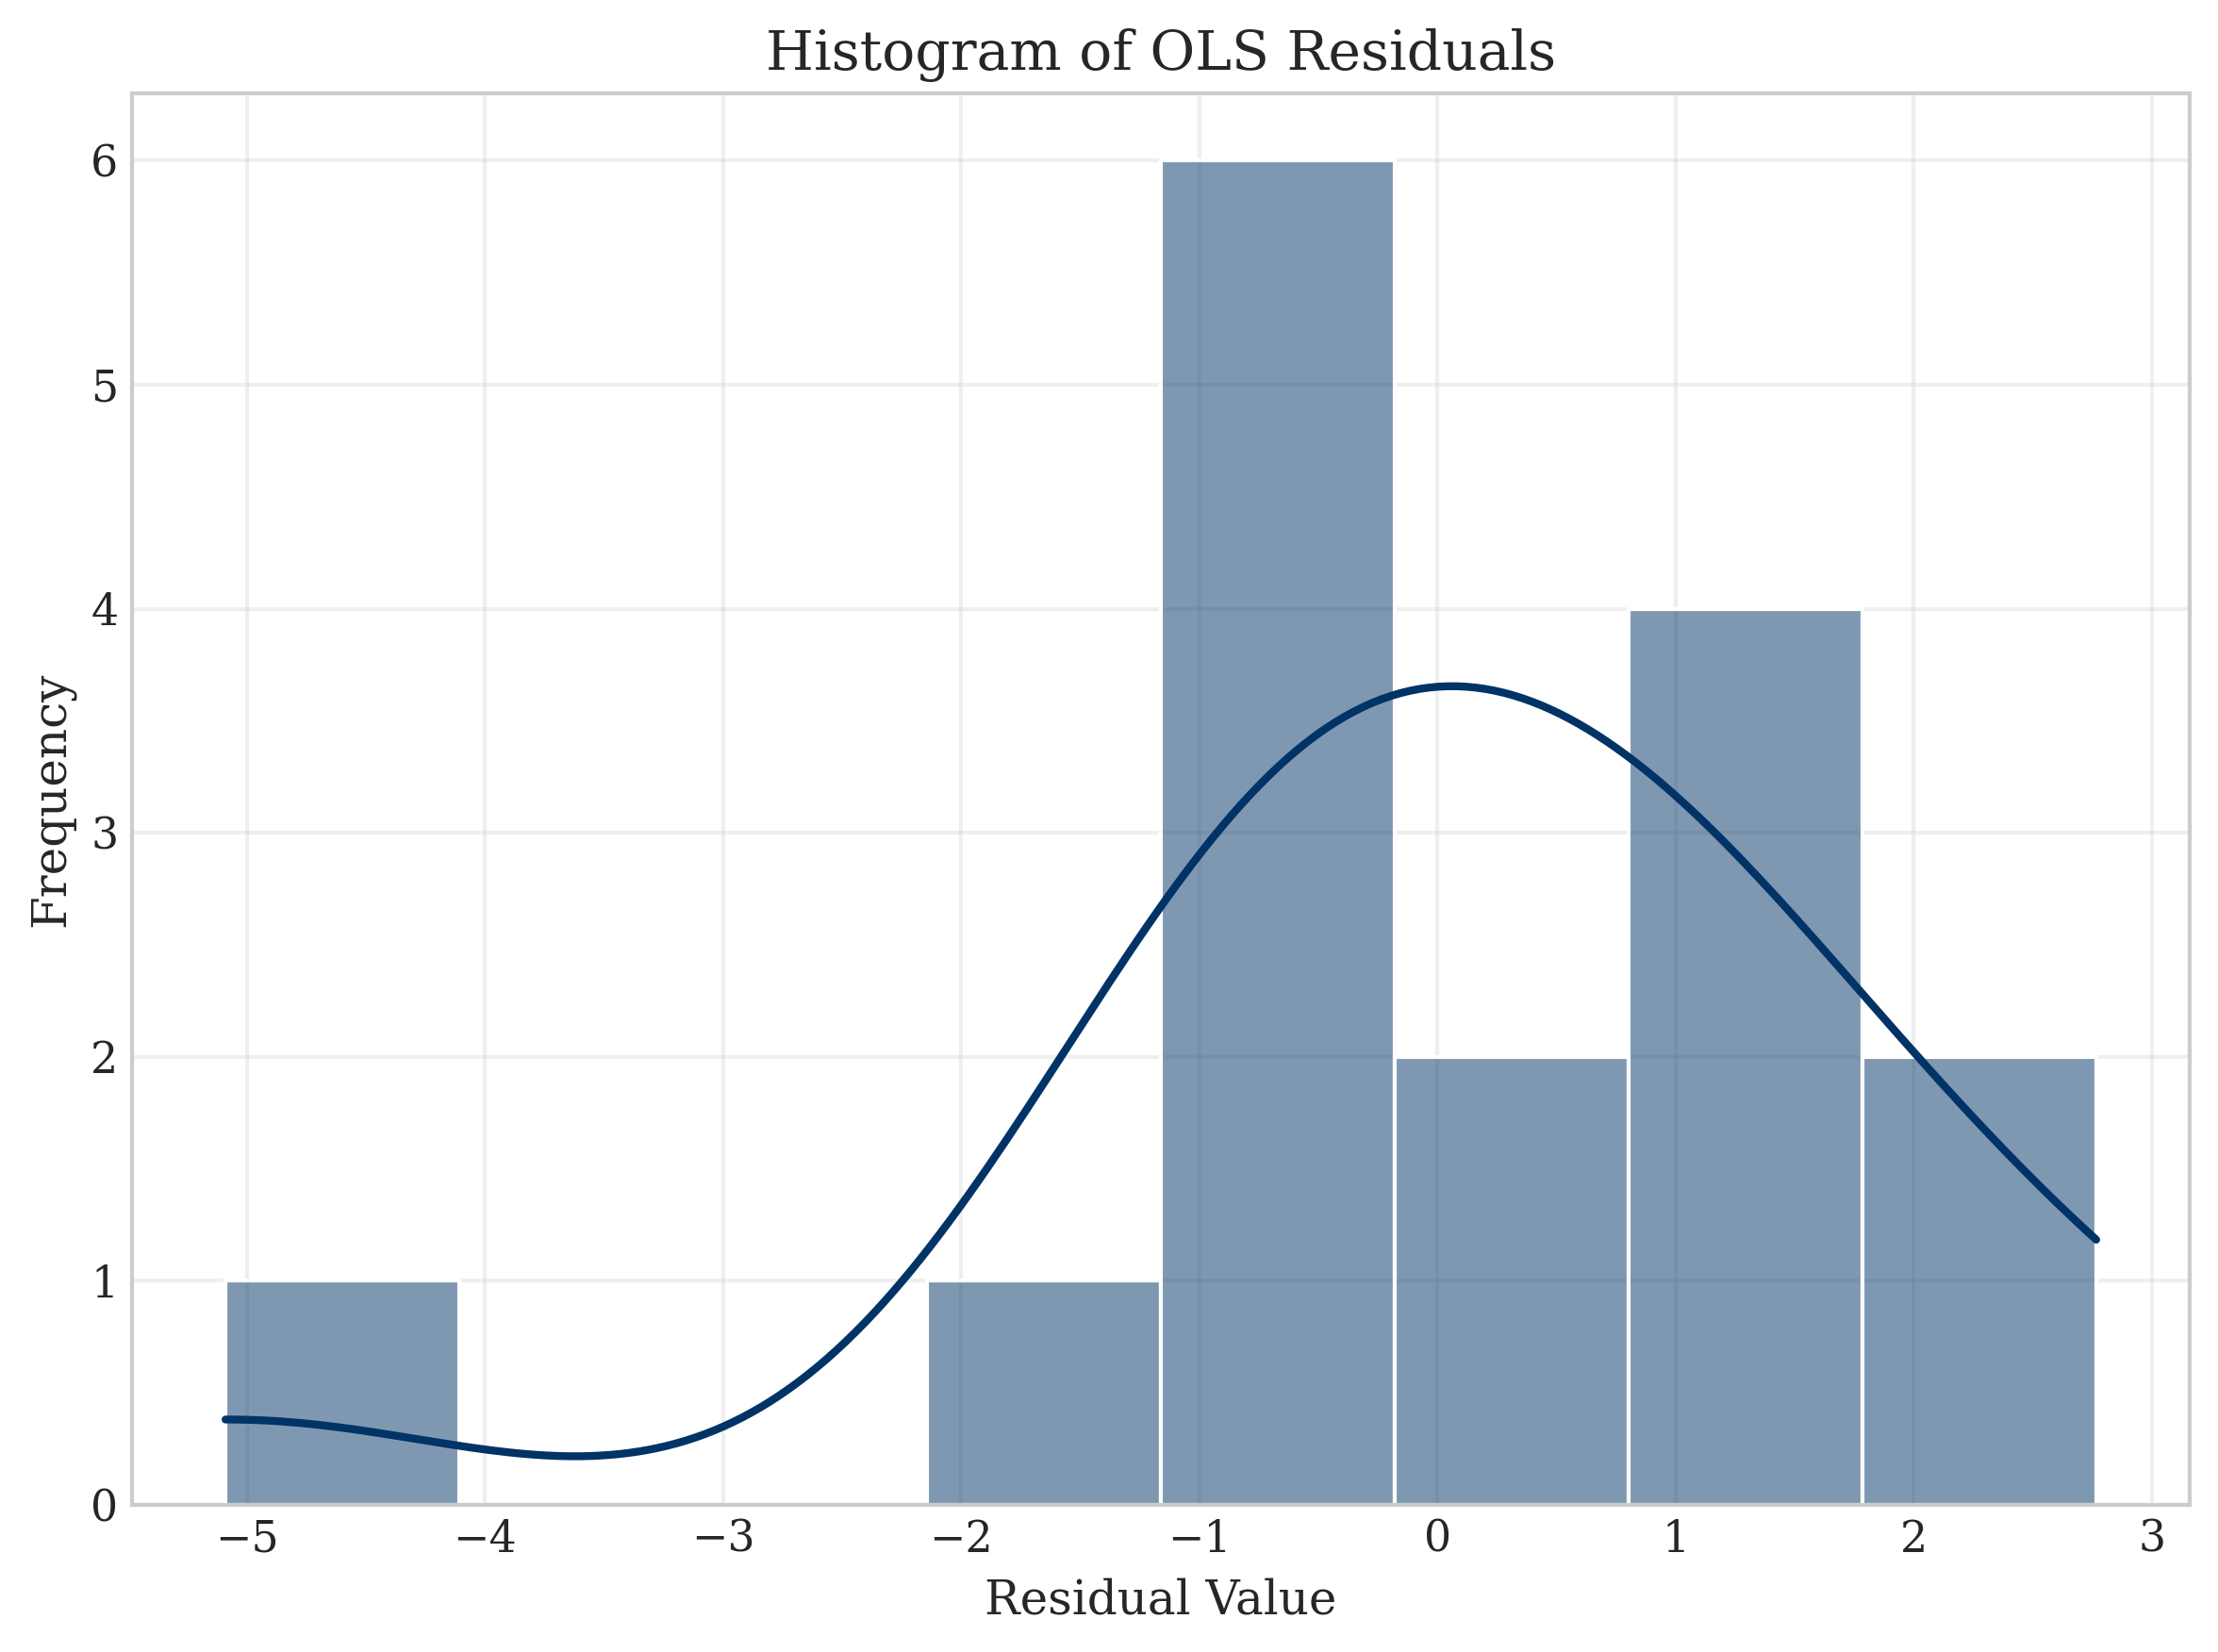

Interpretation: A normal distribution should be bell-shaped.
The bars show the actual frequency of errors.


In [32]:
# --- Visual Analysis: Histogram of Residuals ---
# This provides a second visual check for Normality alongside the Q-Q plot.
plt.figure(figsize=(8, 6))

# Plot Histogram with Kernel Density Estimate (KDE) line
sns.histplot(model_robust.resid, kde=True, color='#003366', bins=8, edgecolor='white')

# Formatting
plt.title('Histogram of OLS Residuals', fontsize=14)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Save
plt.tight_layout()
plt.savefig('figure_histogram.png')
plt.show()

# Interpretation
print("Interpretation: A normal distribution should be bell-shaped.")
print("The bars show the actual frequency of errors.")

In [33]:
# Fit Robust OLS (HAC - Heteroskedasticity and Autocorrelation Consistent)
# maxlags=1 is appropriate for annual data with N=16
model_robust = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

print("--- Robust (HAC) Regression Results ---")
print(model_robust.summary())

# Extract Inflation P-value for discussion
inf_pval = model_robust.pvalues['INFRATE']
print(f"\nRobust P-value for Inflation: {inf_pval:.4f}")
if inf_pval < 0.05:
    print("Conclusion: Significant Positive Relationship (Tobin Effect supported).")
else:
    print("Conclusion: Insignificant Relationship.")

--- Robust (HAC) Regression Results ---
                            OLS Regression Results                            
Dep. Variable:                  GDPGR   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1610.
Date:                Sat, 20 Dec 2025   Prob (F-statistic):           3.87e-15
Time:                        20:34:37   Log-Likelihood:                -31.535
No. Observations:                  16   AIC:                             73.07
Df Residuals:                      11   BIC:                             76.93
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       

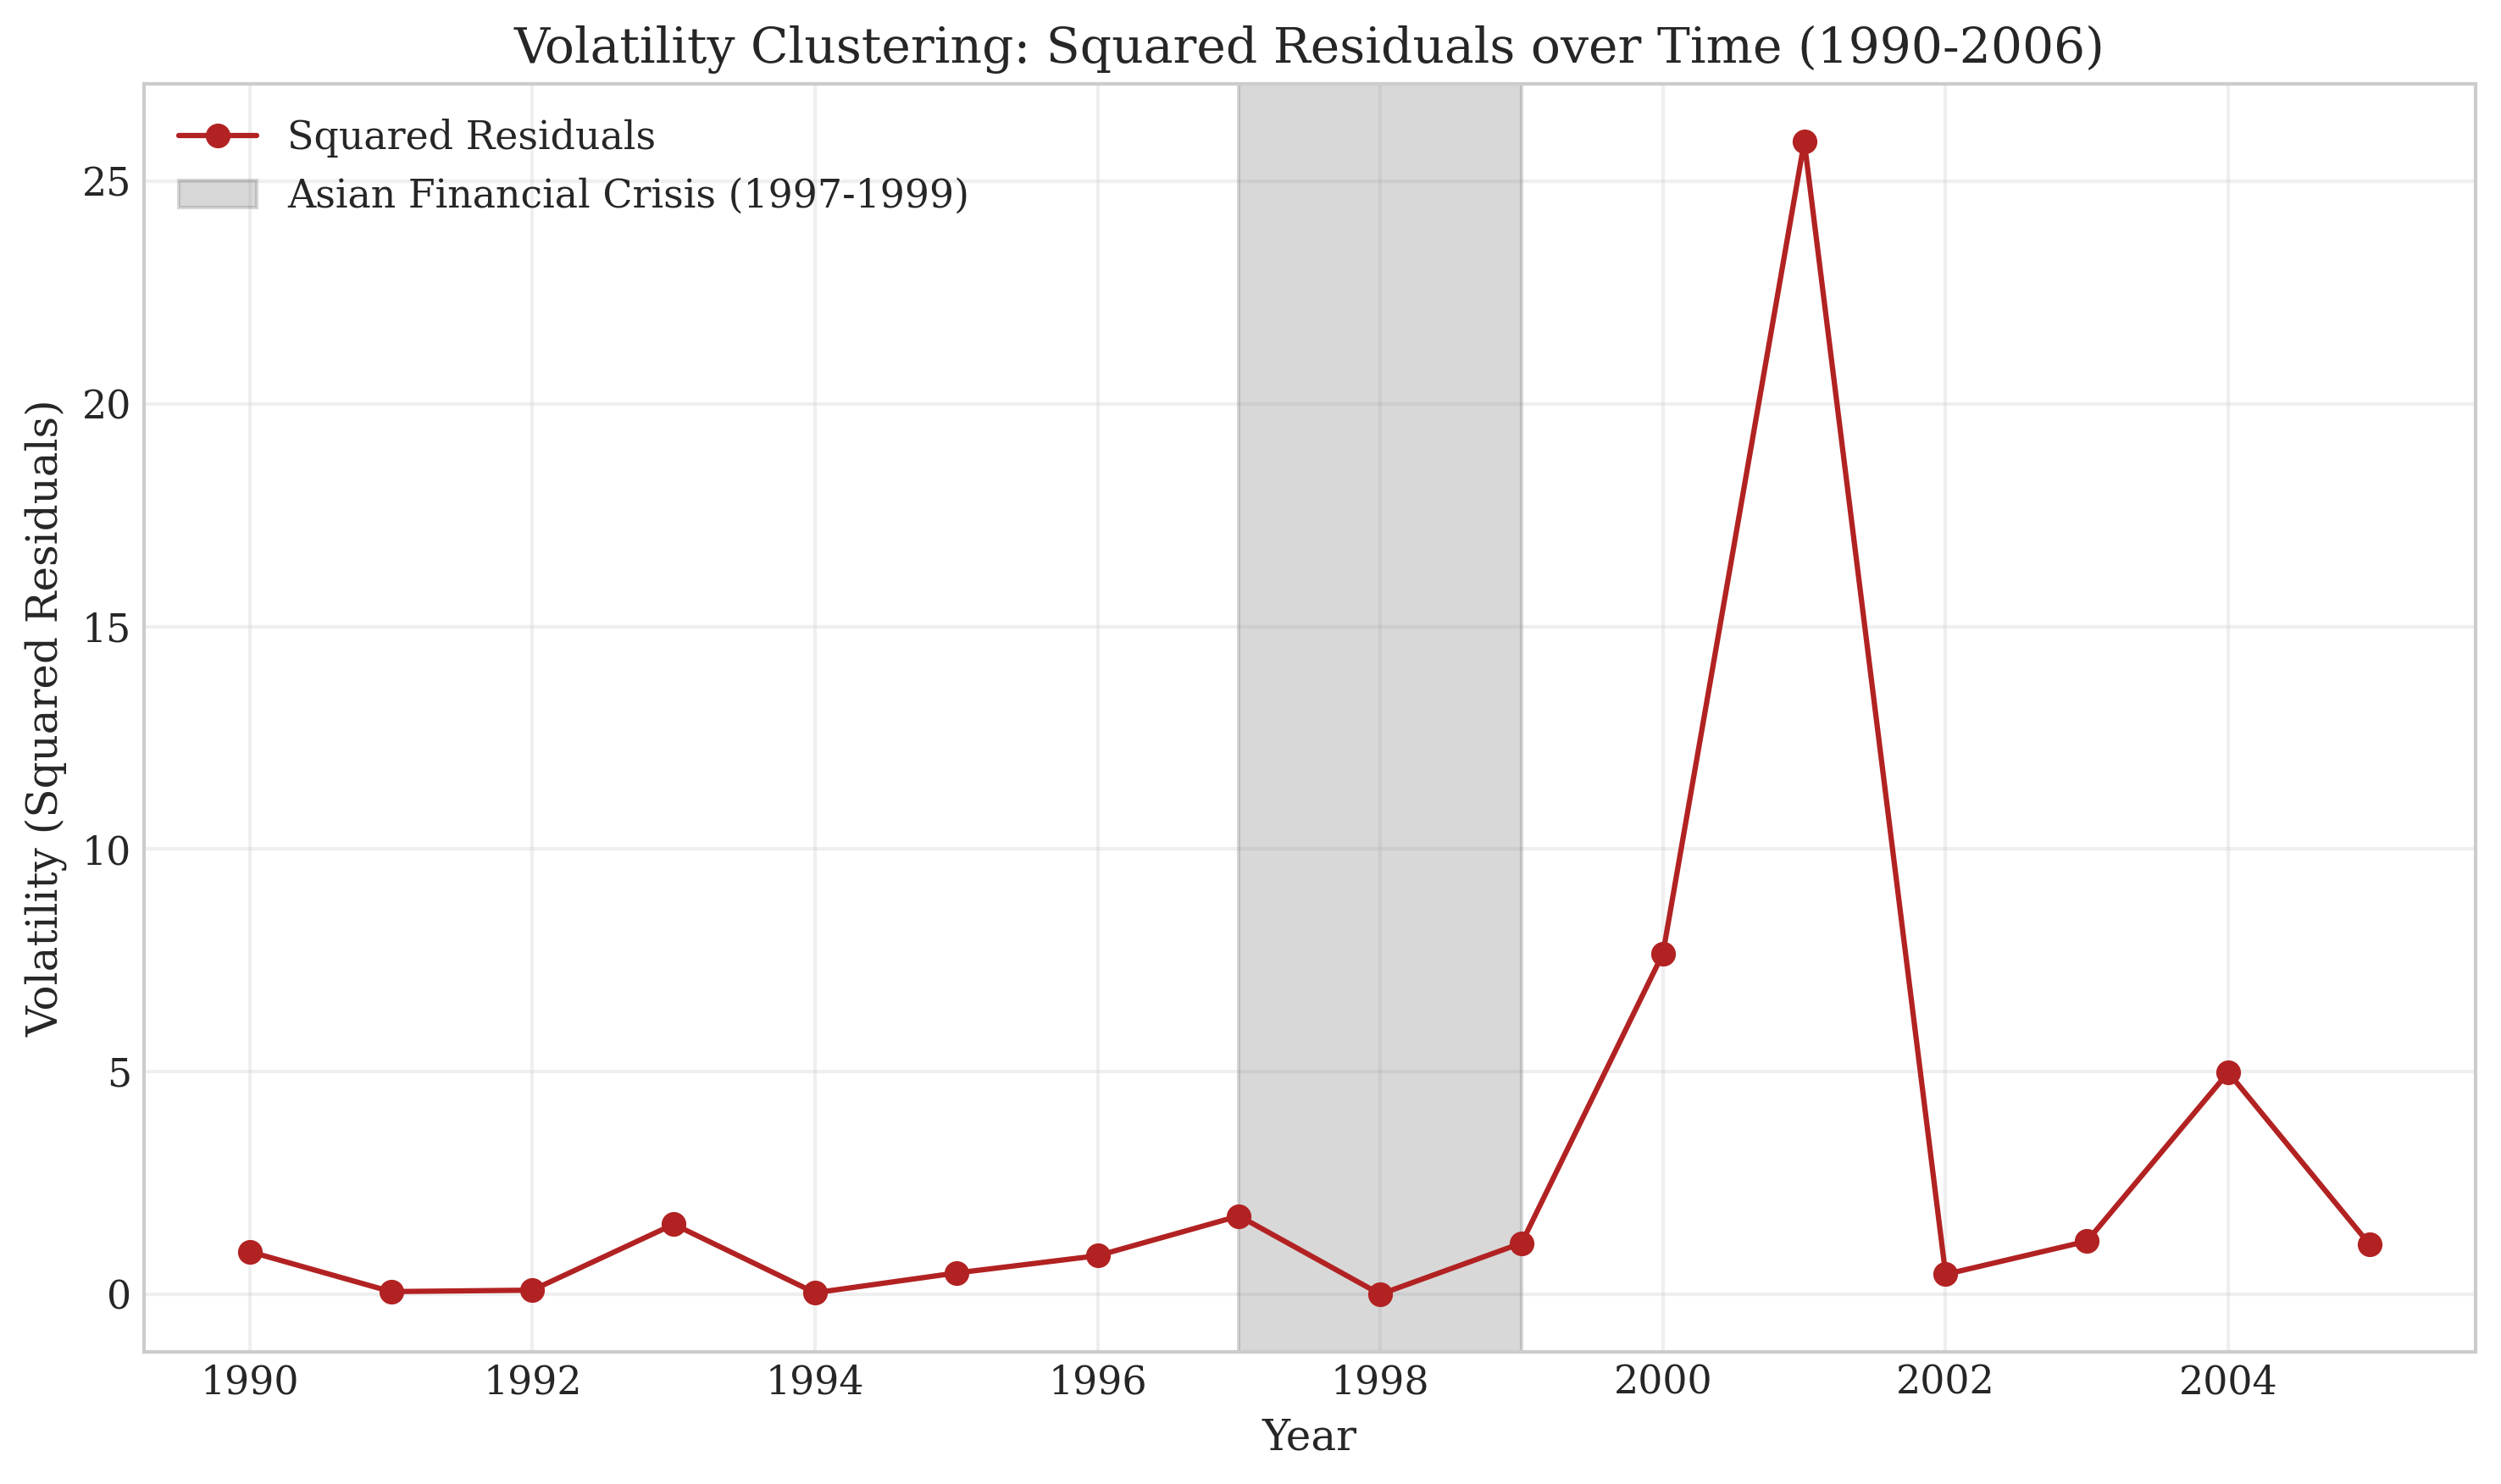

Figure 4 saved successfully.
Interpretation: A huge spike in 1998 indicates that the model's error variance is NOT constant.
This proves the presence of Conditional Heteroskedasticity (ARCH effects).


In [36]:
# --- Volatility Clustering Analysis (Figure 4) ---
# We square the residuals to proxy for "variance" or "risk" over time.

import matplotlib.pyplot as plt

# 1. Calculate Squared Residuals
# model_robust is your HAC OLS model from the previous steps
squared_residuals = model_robust.resid ** 2

# 2. Generate Plot
plt.figure(figsize=(10, 6))
plt.plot(df_model.index, squared_residuals, color='firebrick', marker='o', linestyle='-', linewidth=1.5, label='Squared Residuals')

# 3. Add Context (Highlight the Crisis)
plt.axvspan(1997, 1999, color='gray', alpha=0.3, label='Asian Financial Crisis (1997-1999)')

# 4. Formatting
plt.title('Volatility Clustering: Squared Residuals over Time (1990-2006)', fontsize=14)
plt.ylabel('Volatility (Squared Residuals)')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# 5. Save Figure
plt.tight_layout()
plt.savefig('figure4_volatility.png', dpi=300)
plt.show()

print("Figure 4 saved successfully.")
print("Interpretation: A huge spike in 1998 indicates that the model's error variance is NOT constant.")
print("This proves the presence of Conditional Heteroskedasticity (ARCH effects).")

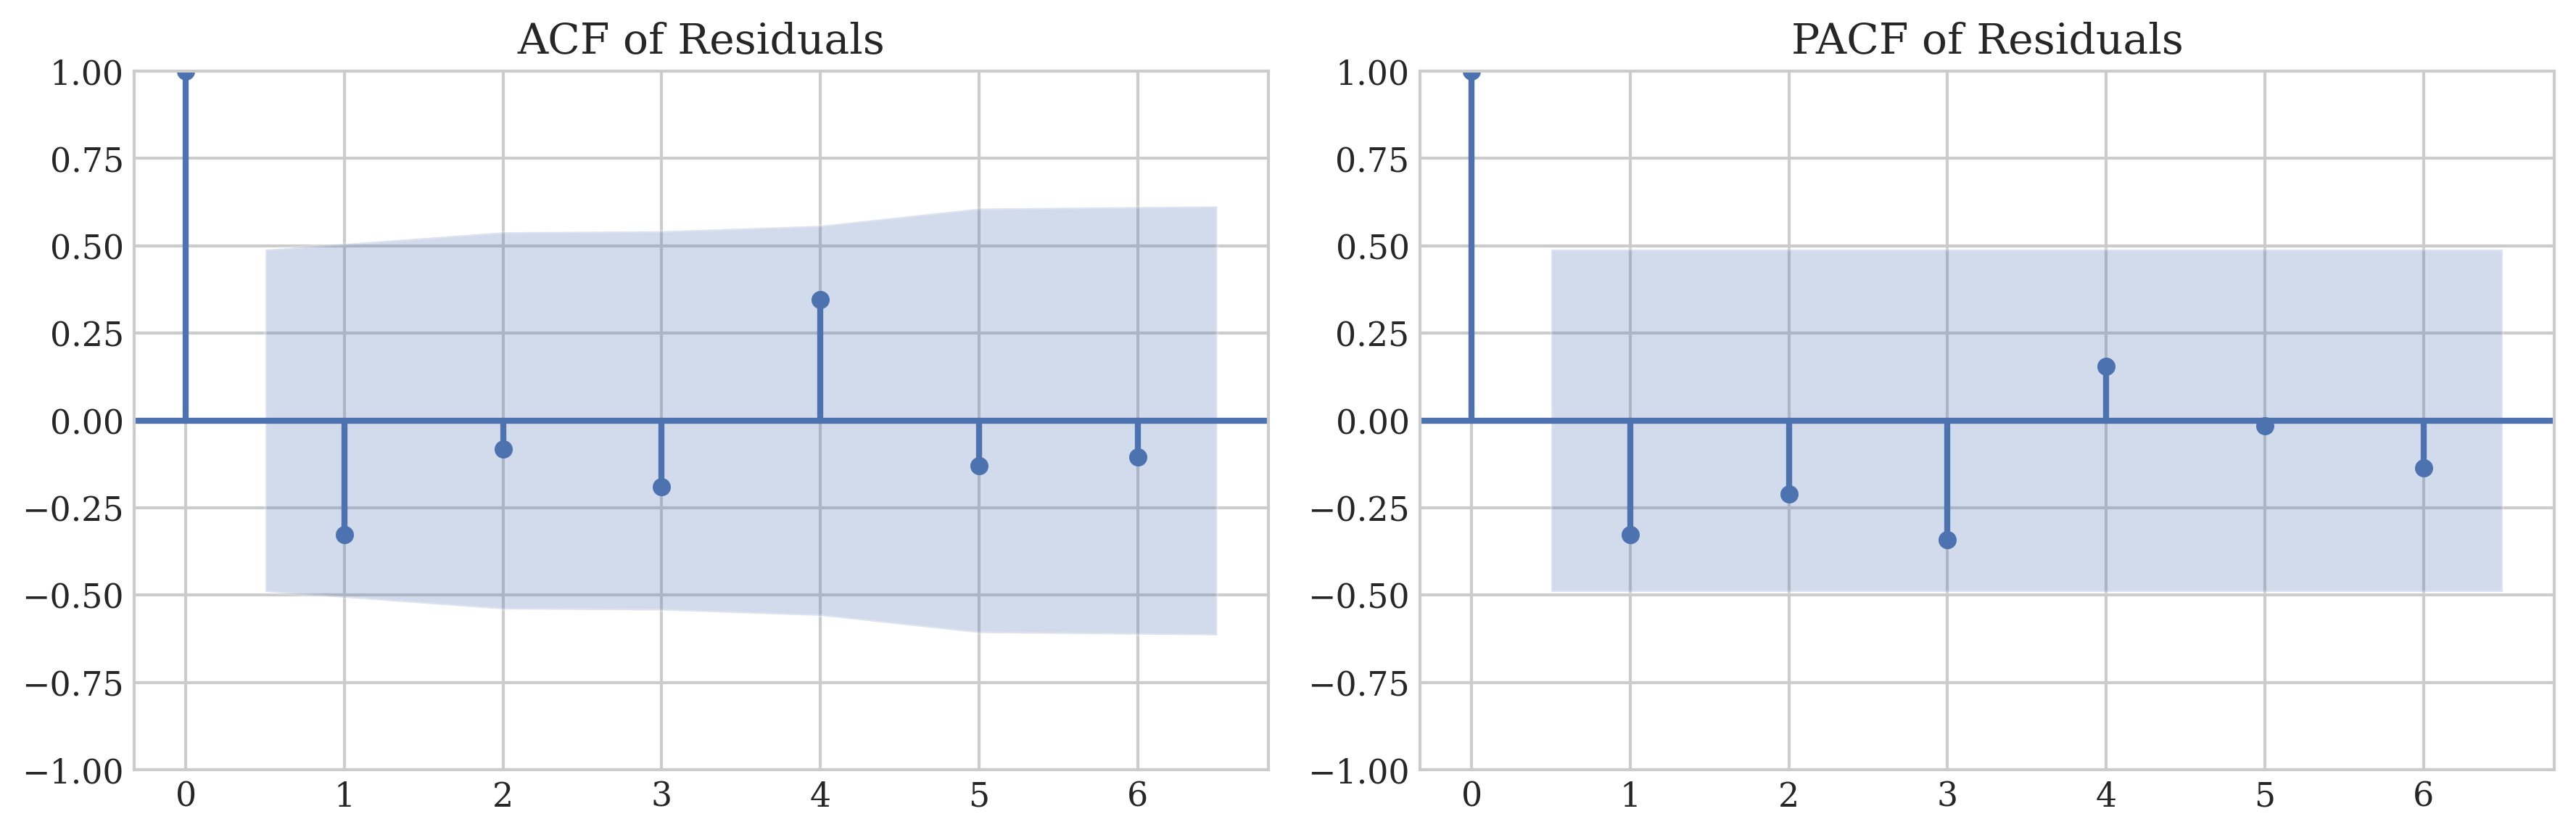

--- ARIMA(1,0,0) Analysis of Residuals ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   16
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -30.644
Date:                Sat, 20 Dec 2025   AIC                             67.288
Time:                        20:34:37   BIC                             69.606
Sample:                             0   HQIC                            67.407
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.351      0.004      0.997      -0.686       0.689
ar.L1         -0.3211      0.177     -1.810      0.070      -0.669       0.027
sigma2   

In [34]:
# Get residuals from the robust model
residuals = model_robust.resid

# 1. Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, lags=6, ax=axes[0], title='ACF of Residuals')
plot_pacf(residuals, lags=6, ax=axes[1], title='PACF of Residuals')
plt.tight_layout()
plt.savefig('residuals_acf_pacf_final.png')
plt.show()

# 2. Fit ARIMA(1, 0, 0) to check for remaining structure
# We treat the residuals as a time series
try:
    arima_model = ARIMA(residuals, order=(1, 0, 0)).fit()
    print("--- ARIMA(1,0,0) Analysis of Residuals ---")
    print(arima_model.summary())
except Exception as e:
    print(f"ARIMA convergence issue: {e}")

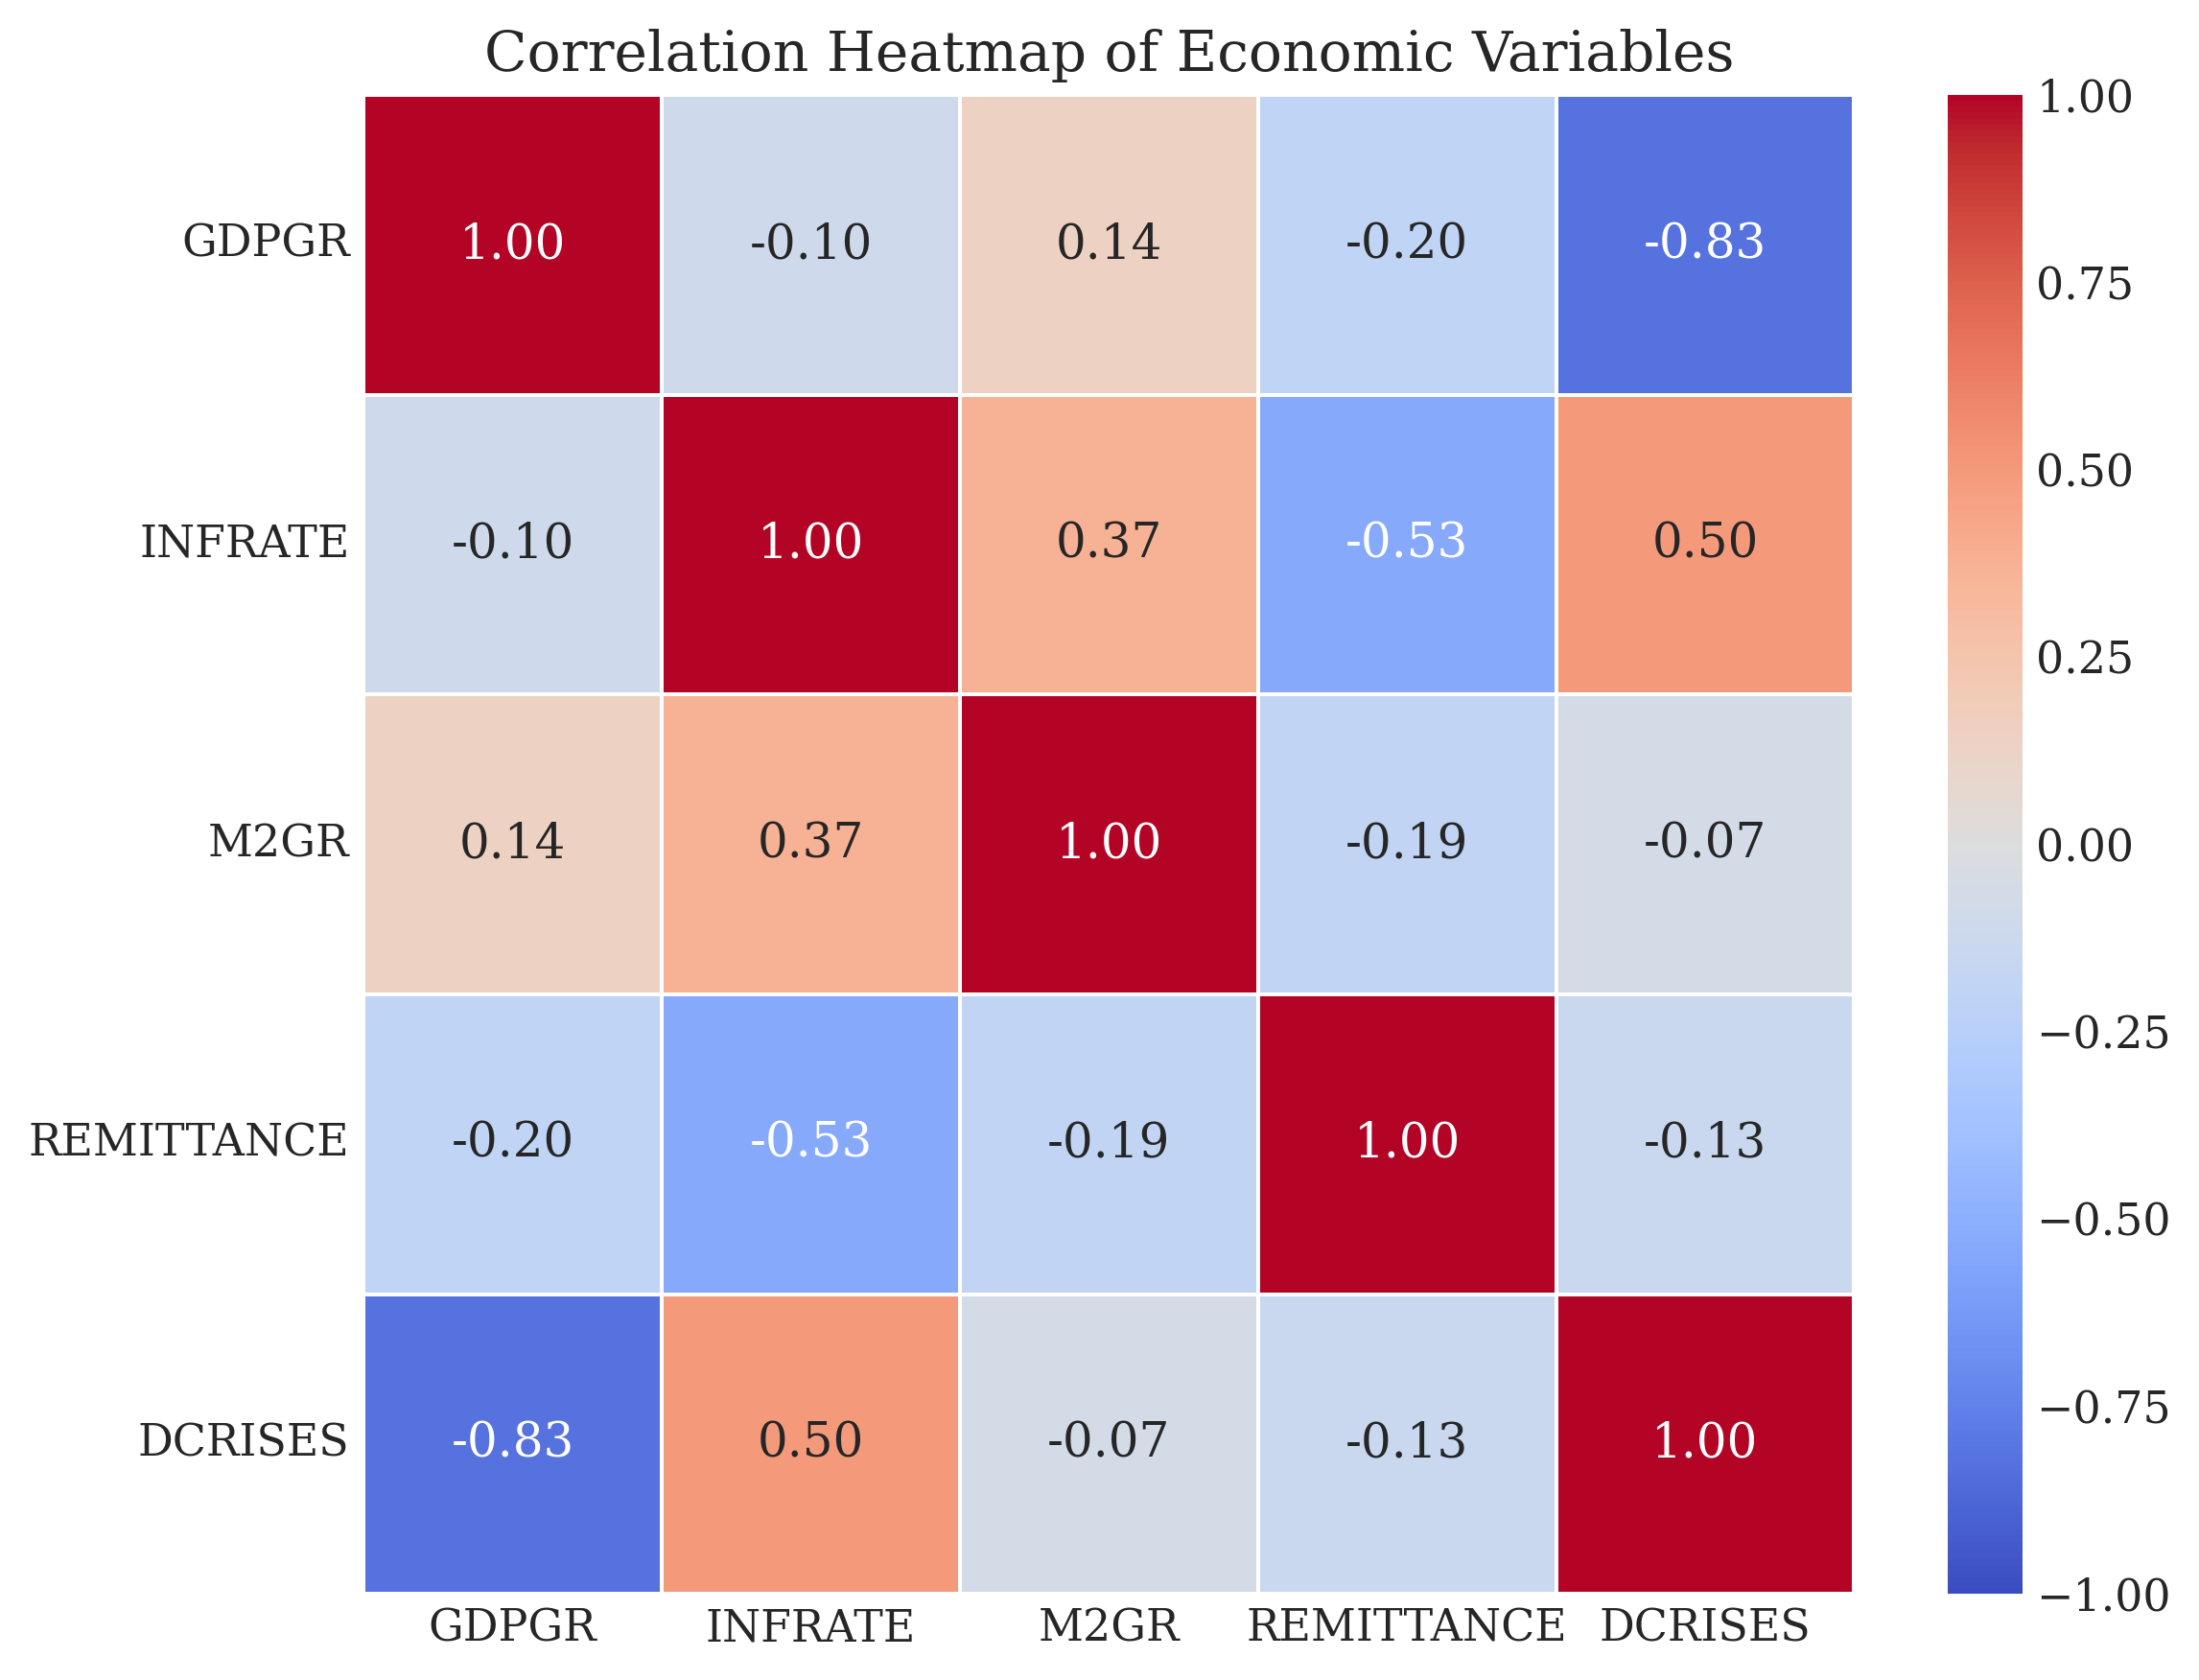

Interpretation:
1. Dark Red/Blue squares indicate strong relationships.
2. Check for high correlations between Independent variables (e.g., > 0.8) to avoid Multicollinearity.


In [35]:
# --- Visual Analysis: Correlation Heatmap ---
# This checks for multicollinearity between variables.
plt.figure(figsize=(8, 6))

# Calculate Correlation Matrix
# We include both Dependent (GDPGR) and Independent variables
corr_matrix = df_model[['GDPGR', 'INFRATE', 'M2GR', 'REMITTANCE', 'DCRISES']].corr()

# Plot Heatmap
sns.heatmap(corr_matrix, 
            annot=True,           # Show numbers
            cmap='coolwarm',      # Red=Positive, Blue=Negative
            vmin=-1, vmax=1,      # Scale from -1 to +1
            center=0,             # White at 0
            fmt='.2f',            # 2 decimal places
            linewidths=0.5,       # Grid lines
            annot_kws={"size": 12}) # Font size

# Formatting
plt.title('Correlation Heatmap of Economic Variables', fontsize=14)
plt.tight_layout()
plt.savefig('figure_heatmap.png')
plt.show()

print("Interpretation:")
print("1. Dark Red/Blue squares indicate strong relationships.")
print("2. Check for high correlations between Independent variables (e.g., > 0.8) to avoid Multicollinearity.")